In [1]:
import mujoco as mj
from mujoco.glfw import glfw
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd


xml_path = 'controlPos.xml'
simend = 15

# file with 0 = pi  and 1 = pi/2
df = pd.read_csv("EMG_RawData_Griselda/senal_cuadrada.csv")
track = df["Signal"]

# For callback functions
button_left = False
button_middle = False
button_right = False
lastx = 0
lasty = 0

posiciones = []
velocidades = []
tiempos = []
control = []

#track = df["Activation"]
#track_value = 0
#i = 0

 #track_value=track[i]
       # i +=1

def controller(model, data):
    """
    This function implements a PD controller

    Since there are no gravity compensation,
    it will not be very accurate at tracking
    the set point. It will be accurate if
    gravity is turned off.
    """
    ctrl_phase = 2 * np.pi  # Control phase
    ctrl_freq = 0.5     # Control frequency
    amplitud = 1
    
    ###################
    
    # Calcular la posición objetivo como una función senoidal
    #target_position = amplitud * np.sin(ctrl_phase + 2 * np.pi * ctrl_freq * data.time)
    
    # funciona para señal continua
    # i= round(data.time/0.002)
    # target_position = track[i]
    
    # Para switching
    i= round(data.time/0.002)
    
    if track[i] == 0:
        target_position = 0
    else:
        target_position =np.pi
    
    ####################
    
    
    if actuator_type == "torque":
        model.actuator_gainprm[0, 0] = 1
        data.ctrl[0] = -10 * (data.sensordata[0] - target_position) - 1 * (data.sensordata[1]) # PD control

    elif actuator_type == "servo":
        kp = 10.0
        model.actuator_gainprm[1, 0] = kp # kp 0 0
        model.actuator_biasprm[1, 1] = -kp # 0 -kp -kv
        data.ctrl[1] = np.pi/2

        #kv = 1.0
        #model.actuator_gainprm[2, 0] = kv
        #model.actuator_biasprm[2, 2] = -kv
        #data.ctrl[2] = 0.2 # m/s, setpoint of the velocity servo, initial velocity?

def keyboard(window, key, scancode, act, mods):
    if act == glfw.PRESS and key == glfw.KEY_BACKSPACE:
        mj.mj_resetData(model, data)
        mj.mj_forward(model, data)

        
def mouse_button(window, button, act, mods):
        # update button state
        button_left = (glfw.get_mouse_button(
            window, glfw.MOUSE_BUTTON_LEFT) == glfw.PRESS)
        button_middle = (glfw.get_mouse_button(
            window, glfw.MOUSE_BUTTON_MIDDLE) == glfw.PRESS)
        button_right = (glfw.get_mouse_button(
            window, glfw.MOUSE_BUTTON_RIGHT) == glfw.PRESS)

        # update mouse position
        glfw.get_cursor_pos(window)

def mouse_move(window, xpos, ypos):
    # compute mouse displacement, save
    global lastx
    global lasty
    dx = xpos - lastx
    dy = ypos - lasty
    lastx = xpos
    lasty = ypos

    # no buttons down: nothing to do
    if (not button_left) and (not button_middle) and (not button_right):
        return

    # get current window size
    width, height = glfw.get_window_size(window)

    # get shift key state
    PRESS_LEFT_SHIFT = glfw.get_key(
        window, glfw.KEY_LEFT_SHIFT) == glfw.PRESS
    PRESS_RIGHT_SHIFT = glfw.get_key(
        window, glfw.KEY_RIGHT_SHIFT) == glfw.PRESS
    mod_shift = (PRESS_LEFT_SHIFT or PRESS_RIGHT_SHIFT)

    # determine action based on mouse button
    if button_right:
        if mod_shift:
            action = mj.mjtMouse.mjMOUSE_MOVE_H
        else:
            action = mj.mjtMouse.mjMOUSE_MOVE_V
    elif button_left:
        if mod_shift:
            action = mj.mjtMouse.mjMOUSE_ROTATE_H
        else:
            action = mj.mjtMouse.mjMOUSE_ROTATE_V
    else:
        action = mj.mjtMouse.mjMOUSE_ZOOM

    mj.mjv_moveCamera(model, action, dx/height,
                      dy/height, scene, cam)

def scroll(window, xoffset, yoffset):
    action = mj.mjtMouse.mjMOUSE_ZOOM
    mj.mjv_moveCamera(model, action, 0.0, -0.05 *
                      yoffset, scene, cam)



In [ ]:
#i= tiempos[8]/0.002
#print(i)
#target_position = track[i]
#print(target_position)

In [ ]:
#print(df["Activation"])

In [ ]:
#track[0]

In [2]:

#get the full path
#dirname = os.path.dirname(__file__)
dirname = os.getcwd() # Use getcwd() to get the current working directory
#abspath = os.path.join(dirname + "/" + xml_path)
abspath = os.path.join(dirname, xml_path)
xml_path = abspath

# MuJoCo data structures
model = mj.MjModel.from_xml_path(xml_path)  # MuJoCo model
data = mj.MjData(model)                # MuJoCo data
cam = mj.MjvCamera()                        # Abstract camera
opt = mj.MjvOption()                        # visualization options

# Init GLFW, create window, make OpenGL context current, request v-sync
glfw.init()
window = glfw.create_window(1200, 900, "Demo", None, None)
glfw.make_context_current(window)
glfw.swap_interval(1)

# initialize visualization data structures
mj.mjv_defaultCamera(cam)
mj.mjv_defaultOption(opt)
scene = mj.MjvScene(model, maxgeom=10000)
context = mj.MjrContext(model, mj.mjtFontScale.mjFONTSCALE_150.value)

# install GLFW mouse and keyboard callbacks
glfw.set_key_callback(window, keyboard)
glfw.set_cursor_pos_callback(window, mouse_move)
glfw.set_mouse_button_callback(window, mouse_button)
glfw.set_scroll_callback(window, scroll)

#set initial conditions
data.qpos[0] = np.pi # to only one degree of freedom '0'

# Set camera configuration
cam.azimuth = 90.0
cam.distance = 5.0
cam.elevation = -5
cam.lookat = np.array([0.012768, -0.000000, 1.254336])

#set the controller
actuator_type = "torque"
mj.set_mjcb_control(controller)

###########################
tiempouno = []


#############
while not glfw.window_should_close(window):
    simstart = data.time
    tiempouno.append(data.time)

    while (data.time - simstart < 0.5/60.0):
        mj.mj_step(model, data)
        #################
        posiciones.append(data.qpos[0])
        velocidades.append(data.qvel[0])
        control.append(data.ctrl[0])
        tiempos.append(data.time)
       
        ####################
        
    if (data.time>=simend):
        break;

    # get framebuffer viewport
    viewport_width, viewport_height = glfw.get_framebuffer_size(
        window)
    viewport = mj.MjrRect(0, 0, viewport_width, viewport_height)

    # Update scene and render
    mj.mjv_updateScene(model, data, opt, None, cam,
                       mj.mjtCatBit.mjCAT_ALL.value, scene)
    mj.mjr_render(viewport, scene, context)

    # swap OpenGL buffers (blocking call due to v-sync)
    glfw.swap_buffers(window)

    # process pending GUI events, call GLFW callbacks
    glfw.poll_events()

glfw.terminate()

In [ ]:
len(posiciones)


In [ ]:
len(velocidades)


In [ ]:
len(control)


In [ ]:
x= range(len(tiempos))

In [ ]:
print(x[1])

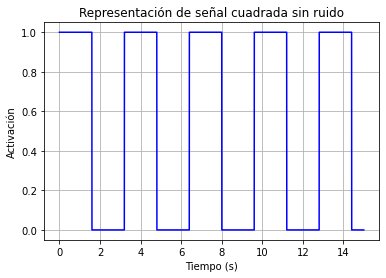

In [11]:
# Crear el gráfico de la señal cuadrada que se usó como referencia
plt.plot(tiempos, track[:len(tiempos)], color='b', label='Posición')

# Agregar etiquetas y título
plt.xlabel('Tiempo (s)')
plt.ylabel('Activación')
plt.title('Representación de señal cuadrada sin ruido')
#plt.legend()  # Mostrar la leyenda
plt.grid(True)  # Agregar una cuadrícula

plt.savefig("SenalCuadradaIdeal.jpg", format="jpg", dpi=300)

# Mostrar el gráfico
plt.show()

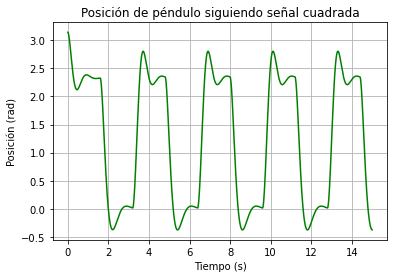

In [12]:
# Crear el gráfico de la señal cuadrada que se usó como referencia
plt.plot(tiempos, posiciones, color='g', label='Posición')

# Agregar etiquetas y título
plt.xlabel('Tiempo (s)')
plt.ylabel('Posición (rad)')
plt.title('Posición de péndulo siguiendo señal cuadrada')
#plt.legend()  # Mostrar la leyenda
plt.grid(True)  # Agregar una cuadrícula

plt.savefig("PosPenduloSenalIdeal.jpg", format="jpg", dpi=300)

# Mostrar el gráfico
plt.show()

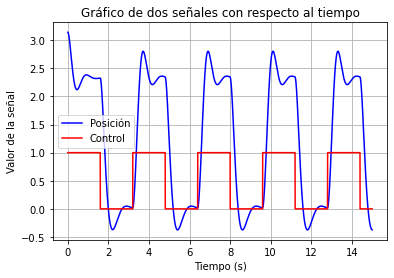

In [7]:
# Señal cuadrada y posición actual
plt.plot(tiempos, posiciones, label='Posición', color='b')  # Graficar señal 1
plt.plot(tiempos, track[:len(tiempos)], label='Control', color='r')  # Graficar señal 2

# Agregar etiquetas y título

plt.xlabel('Tiempo (s)')
plt.ylabel('Valor de la señal')
plt.title('Gráfico de dos señales con respecto al tiempo')
plt.legend()  # Mostrar la leyenda para distinguir las señales
plt.grid(True)  # Agregar una cuadrícula para facilitar la lectura

# Mostrar el gráfico
plt.show()

In [ ]:
# Crear el gráfico
plt.plot(tiempos, velocidades, color='b', label='Posición')

# Agregar etiquetas y título
plt.xlabel('Tiempo (s)')
plt.ylabel('Velocidad (rad/s)')
plt.title('Gráfico de Tiempo vs Velocidad')
plt.legend()  # Mostrar la leyenda
plt.grid(True)  # Agregar una cuadrícula

# Mostrar el gráfico
plt.show()

In [ ]:
# Crear el gráfico
plt.plot(tiempos, control, color='b', label='Posición')

# Agregar etiquetas y título
plt.xlabel('Tiempo (s)')
plt.ylabel('Control ')
plt.title('Gráfico de Tiempo vs Control')
#plt.legend()  # Mostrar la leyenda
plt.grid(True)  # Agregar una cuadrícula

# Mostrar el gráfico
plt.show()

In [ ]:
# Crear el gráfico
plt.plot(df, color='b', label='Posición')

# Agregar etiquetas y título
plt.xlabel('Tiempo (s)')
plt.ylabel('Posición (rad)')
plt.title('Gráfico de Tiempo vs Posición')
plt.legend()  # Mostrar la leyenda
plt.grid(True)  # Agregar una cuadrícula

# Mostrar el gráfico
plt.show()